# Problem Statement

#### 1:Create bounding boxes for each line in the Sanskrit text
#### 2:Save each line in separate jpg files 
#### 3:Save the coordinates of the bounding box in a JSON format

In [232]:
#Importing required libraries

%matplotlib inline
import pytesseract
import cv2
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json
from pdf2image import convert_from_path

pytesseract.pytesseract.tesseract_cmd= r"C:\Program Files\Tesseract-OCR\tesseract.exe"


* To work with OpenCV library, text pdf converted to images and got bounding boxes of all characters present in the image.



* Spent most of the efforts to identify number of lines and characters present in each line.

  1 : Ideally, all characters of same line should have almost same y coordinate which could have given characters of same line.
  
  2 : For given image, all characters of same line have variation in y coordinate. So considered average of y coordinates of each characters to classify characters into different lines.
  
  3 : To identify number of lines present in the image, plotted distribution of averages which showed clustered pattern.
  
  4 : Used K-Means algorithm to find optimal number of clusters which ultimately gives number of lines present in the image and each point in cluster represents character of that line.
  
  
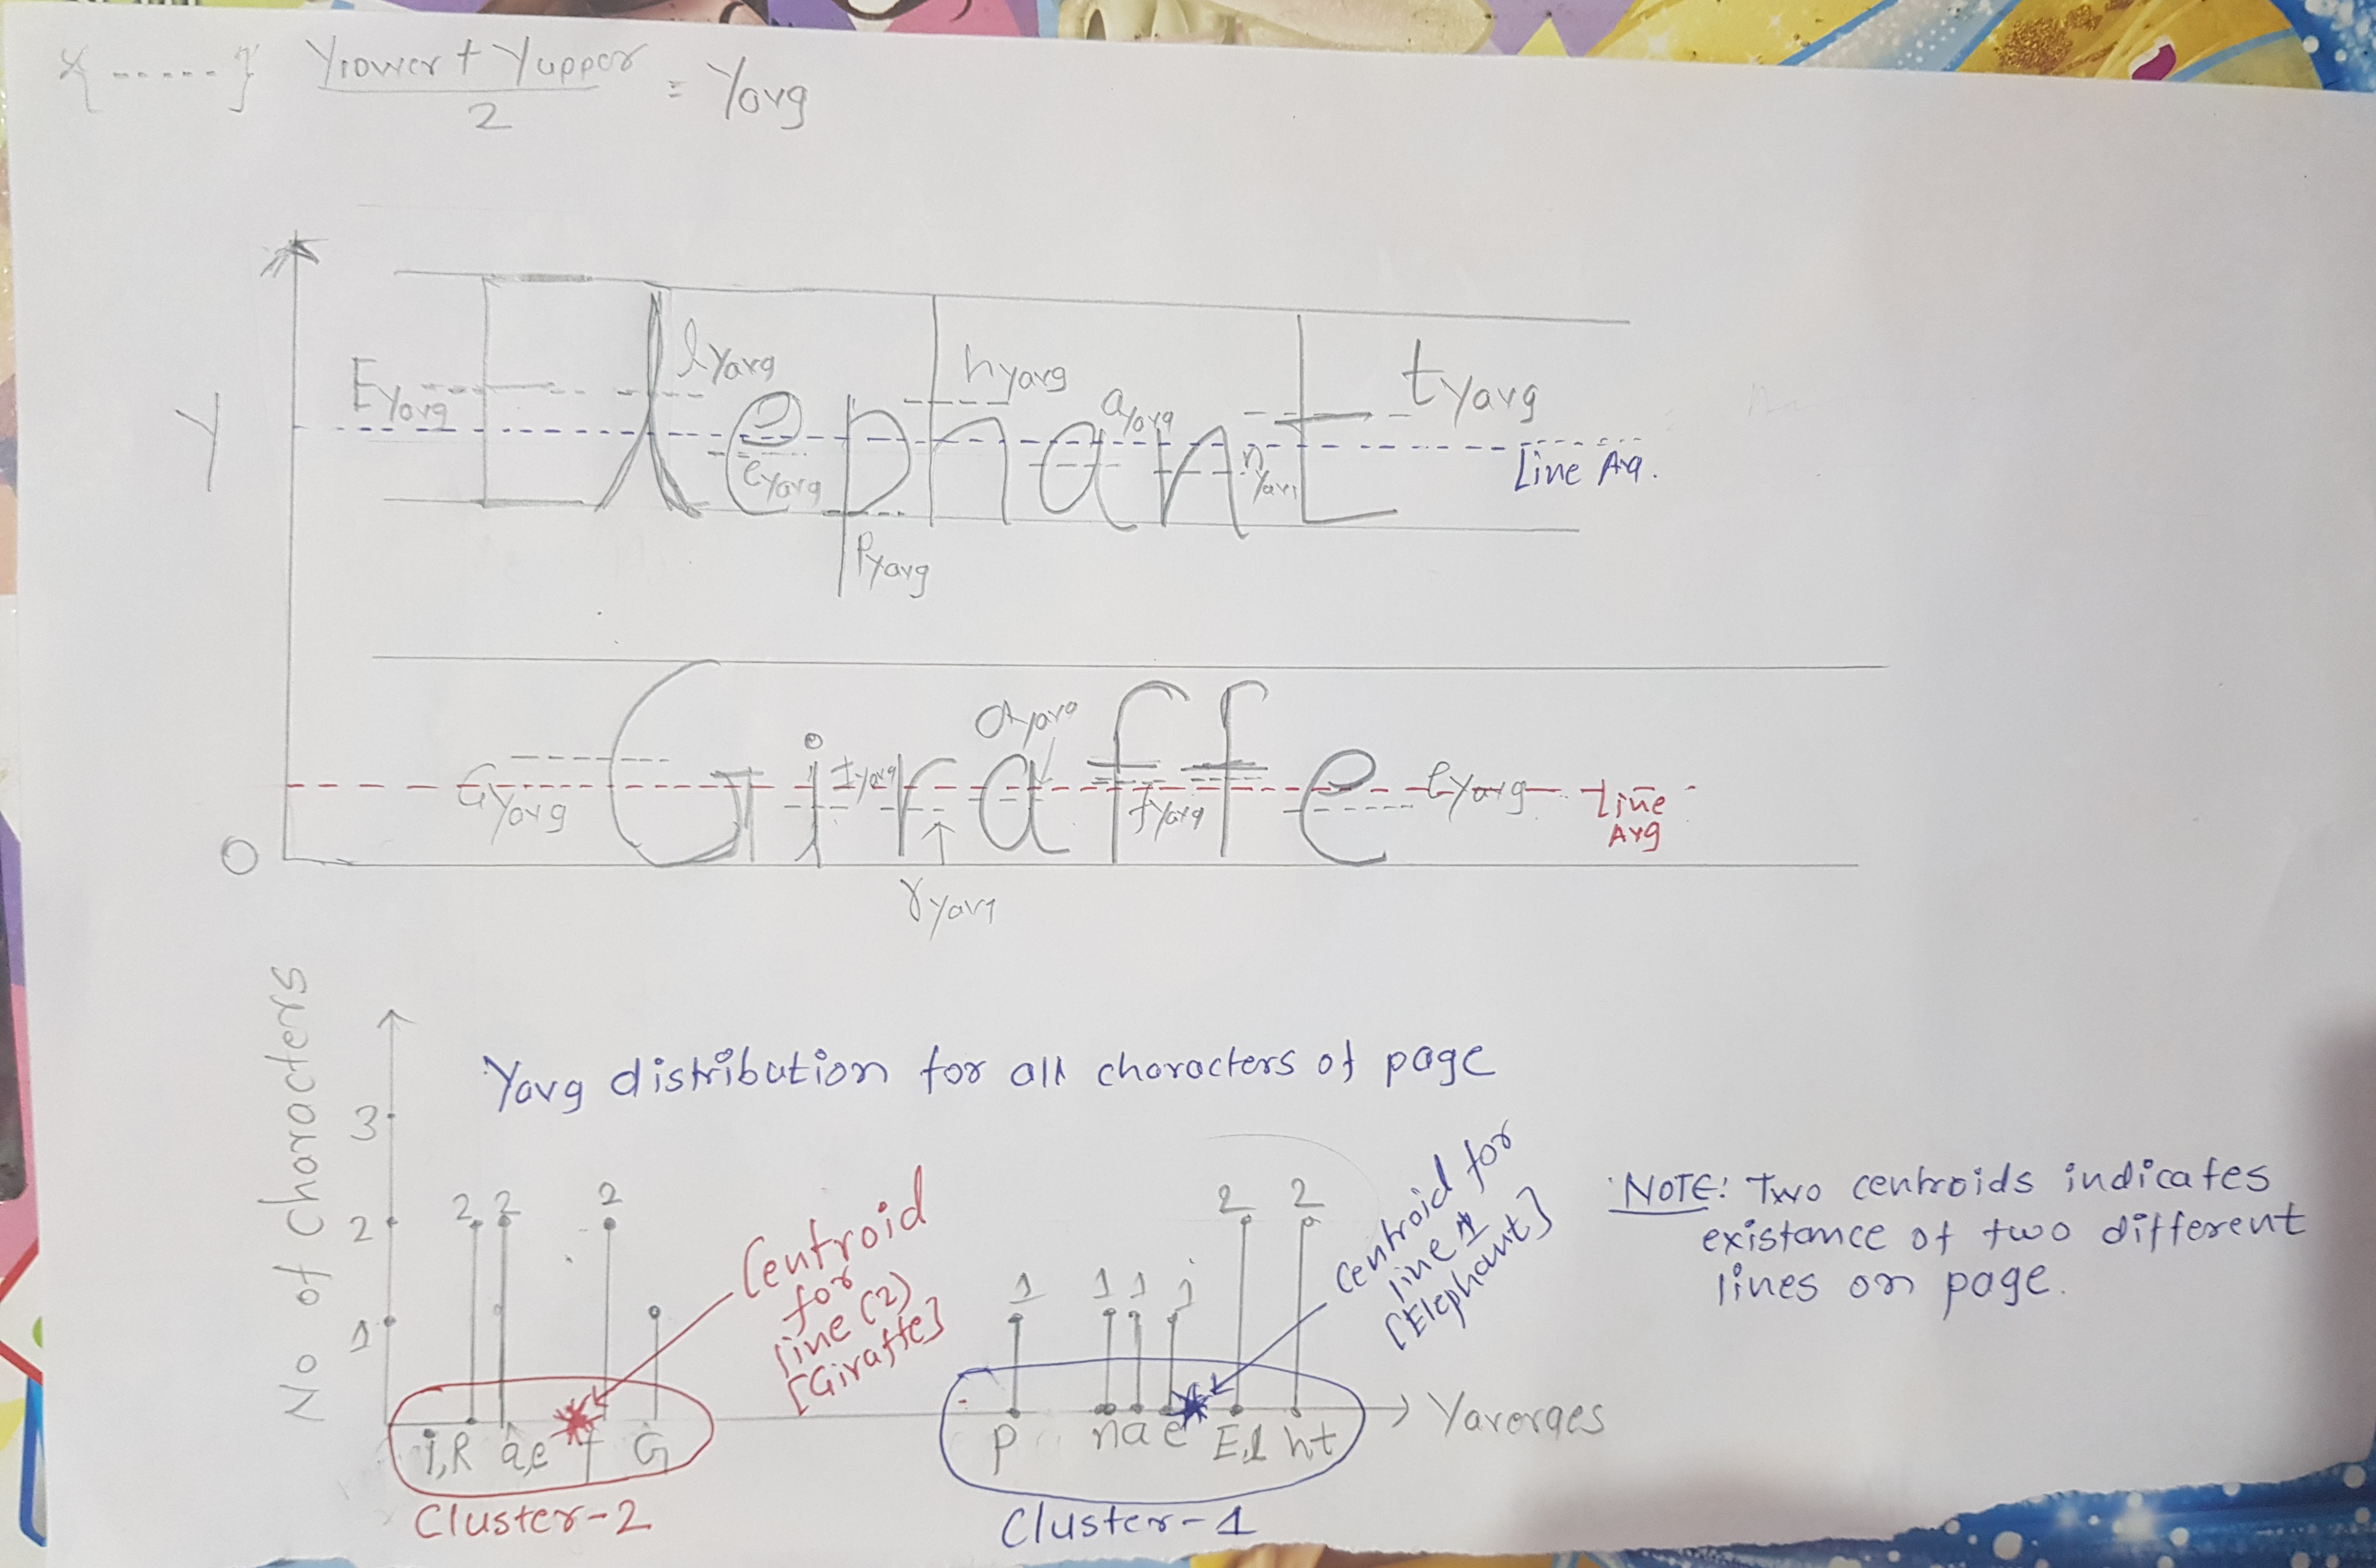


### Defining required fuctions

In [233]:
"""
Function to find out mean y coorinate of each bounding box for all chars available in an image
Outputs : List of values of avg. y coordinate, 
          Dictionary with unique mean y and its frequency {Value of mean y : Frequency}
"""

def finding_box_average():
    
    dict_avg = {}
    val = []
    for box in boxes:
        y_lower = int(box.split( )[2])
        y_upper = int(box.split( )[4])
        
        avg = (y_lower + y_upper)//2
        val.append(avg)
        
        #Creating dictionary with all unique avg height with its frequency
        if avg not in  dict_avg:
            dict_avg[avg] = 1
        else :
            dict_avg[avg] =   dict_avg[avg] + 1
            
    return val, dict_avg

In [234]:
"""
Function to plot Dictionary keys verses dictionary values
Inputs: Dictionary to plot,
        Plot name to provide
"""

def dictionary_plotting(dict_, title):
    plt.figure(figsize=(20,8))
    plt.title(title)
    plt.bar(dict_.keys(), dict_.values())
    plt.show()


In [235]:
"""
Function to find out optimal value of K (Number of clusters ie Lines in Imag) Using Silhoutte score
Input : Numpy array to fit KMeans model
Output : Value of K which maximum Silhoutte score

"""

def OptimalValue_of_K(x):
    sil_score = []
    k_lst =[]
    
    #From all the images, we found that number of lines might vary from 7, 35
    for k in range(7, 35):
        km = KMeans(n_clusters=k, max_iter=300)
        km.fit(x)
        sil_score.append( round(silhouette_score(x, km.labels_),3))
        k_lst.append(k)

    print()
    plt.title('Silhoutte Score vs Number of Clusters')
    plt.plot(range(7,35), sil_score)
    plt.grid()
    plt.show()
    print("For K= {}, Silhoutte score is max: {}".format(k_lst[sil_score.index(max(sil_score))], max(sil_score)))
    
    return k_lst[sil_score.index(max(sil_score))]

In [236]:
"""
Function for fitting average height(input) to ML model to find number of Clusters ie Lines in image
Input :  List of all avg values of height
Output : List of Centroids (Centers of avg height) ,
         List of labels provided model for provided input
"""

def ClusteringOnAverages(val):
    
    x = np.array(val)
    x = x.reshape(-1, 1)
    print("Size of Input Array : ", x.shape)
    
    optimal_k = OptimalValue_of_K(x)
    
    #KMean clustering using optimal value of K
    km = KMeans(n_clusters= optimal_k, max_iter=100)
    km.fit(x)
    
    return km.cluster_centers_, km.labels_

In [237]:
"""
Function to derive dictionary containing list of datapoints for each centroid {centroid1:[index1, index2,...], }
Input : List of Cluster Centers
        List of Labels
Output :Dictonary of list of datapoints for each centroid,
        List of Centroids

"""
def centroid_with_datapoint_box(cluster_centers_, labels_):
     
    lst_center = []
    dict_cenres = {}
    
    for i, center in enumerate(cluster_centers_):
        v=  int(center[0]) 
        lst_center.append(v)
        temp = []
        for pos,label in enumerate(labels_):
            if label==i:
                temp.append(pos)
        dict_cenres[v] = temp
        
    return dict_cenres, lst_center

In [238]:
"""
Function to create list of coordinates of each line in image
Input : List of all bounding boxes for centroid [box1, box2 ,...]
Output : List of Cordinates [lower left x, lower left y, upper right x, upper right y]

"""
def imageCordinatesfromBox(lst_box):
    
    llx = []; lly = []; urx = []; ury = []
        
    for box in lst_box:
        llx.append(int(box.split(" ")[1]))
        lly.append(int(box.split(" ")[2]))
        
        urx.append(int(box.split(" ")[3]))
        ury.append(int(box.split(" ")[4]))

    llx_sort = llx.sort()
    lly_sort = lly.sort()
    urx_sort = urx.sort()
    ury_sort = ury.sort()
           
    llx_final = llx[0]
    lly_final = lly[0]
    urx_final = urx[-1]
    ury_final = ury[-1]
        
    size = [llx_final,  lly_final, urx_final, ury_final]
    return size

In [239]:
"""
Function  1: To crop reuired part of image, 2: Save each line of text into jpg image 3: Finding bounding boxes per text line  

Input: List of Centroid [C1, C2,...],
       List of Cordinates [lower left x, lower left y, upper right x, upper right y],
       Name of image (to derive names of images foreach lines per image)
       Total  counts of bounding boxes 
       Dictionary to store coorinates of each text line ie for each box {box1:[top_left, top_right, bottom_left, bottom_right]}

Output : List of image(for each text line) names ,
        Updated Dictionary to store coorinates of each text line with cordinates of given image.,
        Updated counts of bounding boxes 
       
"""

def croppingImage(lst_center, size,  imgName, count, json_dict):

    nm_lst = []
    
    for i in  range(len(lst_center)):
 
        img = cv2.cvtColor(cv2.imread(imgName+".jpg"), cv2.COLOR_BGR2RGB)
        
        center = lst_center[i]
       
        #Name of extracted image
        name= f"{imgName}_cropped_{i}.jpg"
        nm_lst.append(name)
        
        print("Centriod:{},  Name of Image: {}".format(center, name ))
        
        cord= size[center]
    
        # Creating bounding boxes around image with line
        x1 = cord[0]; y1 =(img.shape[0] - cord[3]); x2 = cord[2]; y2=(img.shape[0] - cord[1])
        bouding_img = cv2.rectangle(img,  (x1, y1), (x2,y2), color = (0,0,255), thickness=1)
        cropped_img = bouding_img[(img.shape[0] - cord[3]-2):(img.shape[0] - cord[1]+2) ,  cord[0] -50  :cord[2]+50 ]
        
        #To Create Bounding Boxes for each Text Line(Not for word)
        top_left = [x1, y2]; top_right=[x2, y2]; bottom_left = [x1, y1]; bottom_right= [x2,y1]
        dict_ = {
                    "top_left": top_left,
                    "top_right" :top_right,
                    "bottom_left" : bottom_left,
                    "bottom_right" : bottom_right 
                }
        
        name = "box"+str(count)
        json_dict[name]= dict_
        print("{}: {}".format(name, dict_))
        
        #Saving  each line of text into jpg image
        cv2.imwrite(nm_lst[i], cropped_img)
        
        
        plt.imshow(cropped_img)
        plt.show()
        
        count +=1
        print()
        
    return nm_lst, json_dict, count


List of image names:  ['page0.jpg', 'page1.jpg', 'page2.jpg', 'page3.jpg', 'page4.jpg']
Shape of image :  (2200, 1700, 3)


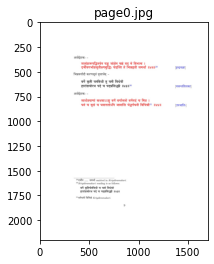

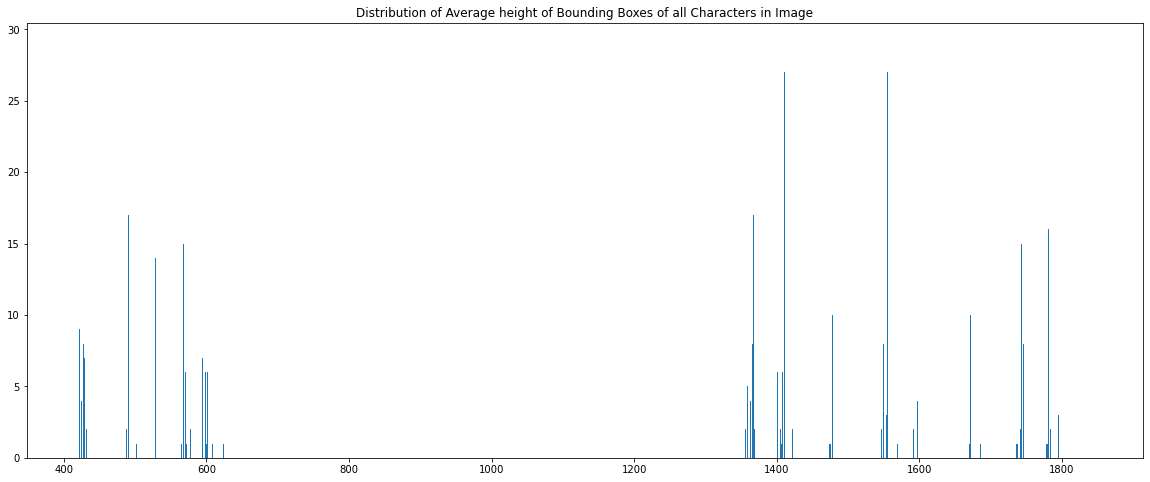

Size of Input Array :  (516, 1)



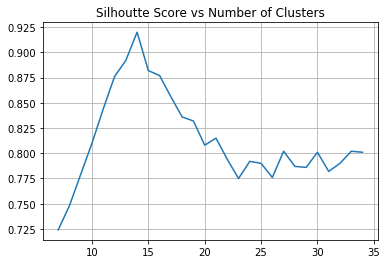

For K= 14, Silhoutte score is max: 0.92

Centroids of image : [527, 1553, 1741, 1364, 425, 601, 1672, 1409, 1600, 1781, 490, 569, 1477, 1841]

Centriod:527,  Name of Image: page0_cropped_0.jpg
box0: {'top_left': [405, 1691], 'top_right': [745, 1691], 'bottom_left': [405, 1658], 'bottom_right': [745, 1658]}


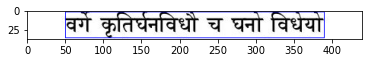


Centriod:1553,  Name of Image: page0_cropped_1.jpg
box1: {'top_left': [414, 668], 'top_right': [1521, 668], 'bottom_left': [414, 626], 'bottom_right': [1521, 626]}


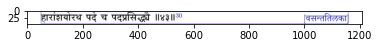


Centriod:1741,  Name of Image: page0_cropped_2.jpg
box2: {'top_left': [414, 479], 'top_right': [1462, 479], 'bottom_left': [414, 438], 'bottom_right': [1462, 438]}


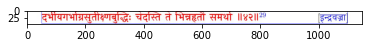


Centriod:1364,  Name of Image: page0_cropped_3.jpg
box3: {'top_left': [414, 859], 'top_right': [1471, 859], 'bottom_left': [414, 817], 'bottom_right': [1471, 817]}


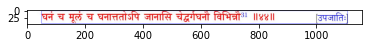


Centriod:425,  Name of Image: page0_cropped_4.jpg
box4: {'top_left': [364, 1788], 'top_right': [710, 1788], 'bottom_left': [364, 1759], 'bottom_right': [710, 1759]}


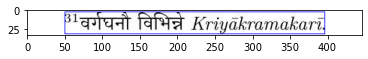


Centriod:601,  Name of Image: page0_cropped_5.jpg
box5: {'top_left': [340, 1611], 'top_right': [868, 1611], 'bottom_left': [340, 1575], 'bottom_right': [868, 1575]}


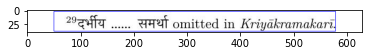


Centriod:1672,  Name of Image: page0_cropped_6.jpg
box6: {'top_left': [338, 546], 'top_right': [695, 546], 'bottom_left': [338, 509], 'bottom_right': [695, 509]}


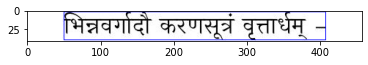


Centriod:1409,  Name of Image: page0_cropped_7.jpg
box7: {'top_left': [414, 814], 'top_right': [1099, 814], 'bottom_left': [414, 773], 'bottom_right': [1099, 773]}


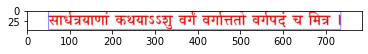


Centriod:1600,  Name of Image: page0_cropped_8.jpg
box8: {'top_left': [414, 623], 'top_right': [839, 623], 'bottom_left': [414, 582], 'bottom_right': [839, 582]}


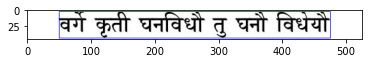


Centriod:1781,  Name of Image: page0_cropped_9.jpg
box9: {'top_left': [414, 437], 'top_right': [1056, 437], 'bottom_left': [414, 400], 'bottom_right': [1056, 400]}


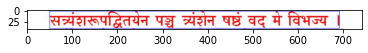


Centriod:490,  Name of Image: page0_cropped_10.jpg
box10: {'top_left': [405, 1725], 'top_right': [800, 1725], 'bottom_left': [405, 1694], 'bottom_right': [800, 1694]}


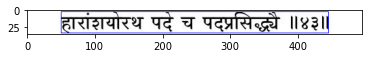


Centriod:569,  Name of Image: page0_cropped_11.jpg
box11: {'top_left': [364, 1642], 'top_right': [800, 1642], 'bottom_left': [364, 1616], 'bottom_right': [800, 1616]}


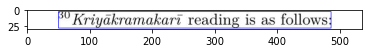


Centriod:1477,  Name of Image: page0_cropped_12.jpg
box12: {'top_left': [341, 739], 'top_right': [484, 739], 'bottom_left': [341, 705], 'bottom_right': [484, 705]}


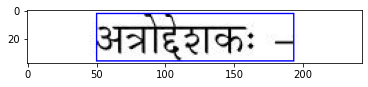


Centriod:1841,  Name of Image: page0_cropped_13.jpg
box13: {'top_left': [341, 375], 'top_right': [484, 375], 'bottom_left': [341, 341], 'bottom_right': [484, 341]}


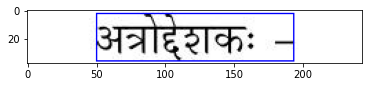






Shape of image :  (2200, 1700, 3)


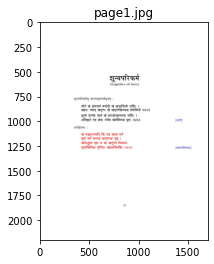

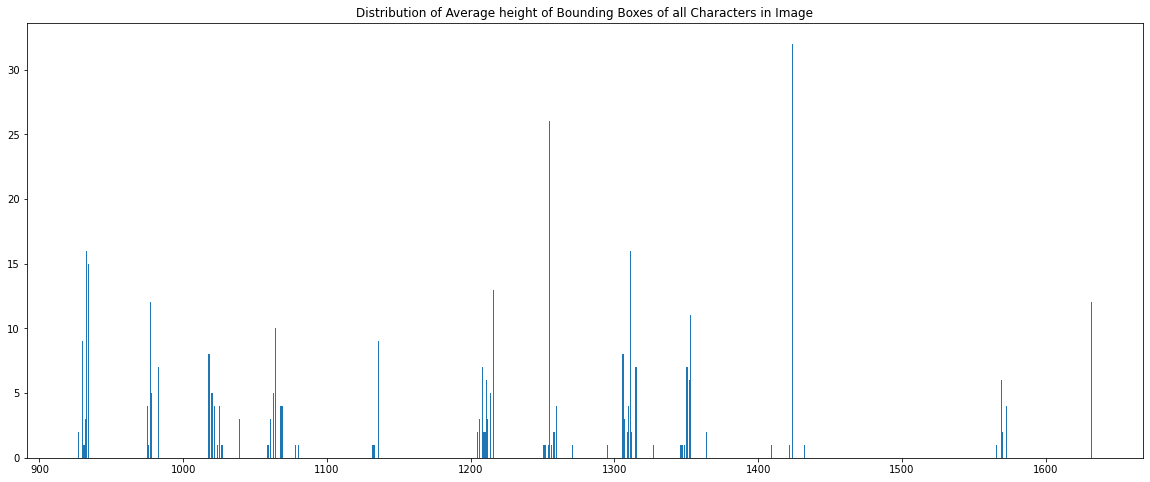

Size of Input Array :  (361, 1)



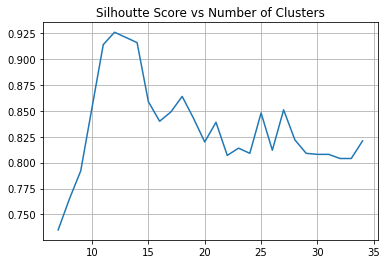

For K= 12, Silhoutte score is max: 0.926

Centroids of image : [1352, 1023, 1570, 1255, 932, 1065, 1423, 1310, 1211, 1632, 1135, 978]

Centriod:1352,  Name of Image: page1_cropped_0.jpg
box14: {'top_left': [414, 868], 'top_right': [992, 868], 'bottom_left': [414, 831], 'bottom_right': [992, 831]}


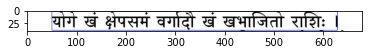


Centriod:1023,  Name of Image: page1_cropped_1.jpg
box15: {'top_left': [414, 1197], 'top_right': [814, 1197], 'bottom_left': [414, 1158], 'bottom_right': [814, 1158]}


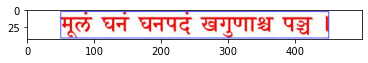


Centriod:1570,  Name of Image: page1_cropped_2.jpg
box16: {'top_left': [707, 646], 'top_right': [993, 646], 'bottom_left': [707, 613], 'bottom_right': [993, 613]}


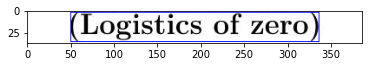


Centriod:1255,  Name of Image: page1_cropped_3.jpg
box17: {'top_left': [414, 965], 'top_right': [972, 965], 'bottom_left': [414, 924], 'bottom_right': [972, 924]}


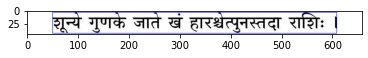


Centriod:932,  Name of Image: page1_cropped_4.jpg
box18: {'top_left': [414, 1288], 'top_right': [1521, 1288], 'bottom_left': [414, 1247], 'bottom_right': [1521, 1247]}


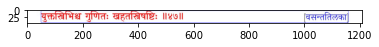


Centriod:1065,  Name of Image: page1_cropped_5.jpg
box19: {'top_left': [414, 1156], 'top_right': [839, 1156], 'bottom_left': [414, 1115], 'bottom_right': [839, 1115]}


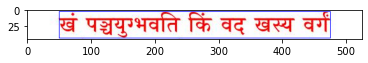


Centriod:1423,  Name of Image: page1_cropped_6.jpg
box20: {'top_left': [339, 794], 'top_right': [742, 794], 'bottom_left': [339, 757], 'bottom_right': [742, 757]}


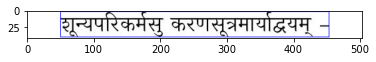


Centriod:1310,  Name of Image: page1_cropped_7.jpg
box21: {'top_left': [414, 909], 'top_right': [1104, 909], 'bottom_left': [414, 868], 'bottom_right': [1104, 868]}


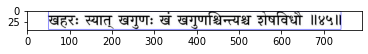


Centriod:1211,  Name of Image: page1_cropped_8.jpg
box22: {'top_left': [417, 1010], 'top_right': [1430, 1010], 'bottom_left': [417, 968], 'bottom_right': [1430, 968]}


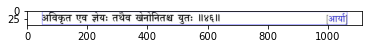


Centriod:1632,  Name of Image: page1_cropped_9.jpg
box23: {'top_left': [697, 610], 'top_right': [1003, 610], 'bottom_left': [697, 526], 'bottom_right': [1003, 526]}


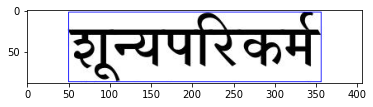


Centriod:1135,  Name of Image: page1_cropped_10.jpg
box24: {'top_left': [340, 1081], 'top_right': [484, 1081], 'bottom_left': [340, 1047], 'bottom_right': [484, 1047]}


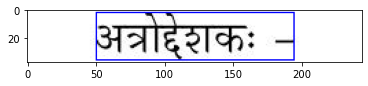


Centriod:978,  Name of Image: page1_cropped_11.jpg
box25: {'top_left': [414, 1245], 'top_right': [883, 1245], 'bottom_left': [414, 1201], 'bottom_right': [883, 1201]}


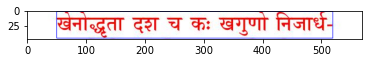






Shape of image :  (2200, 1700, 3)


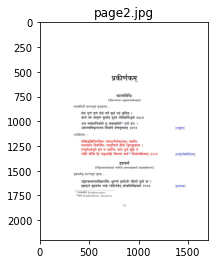

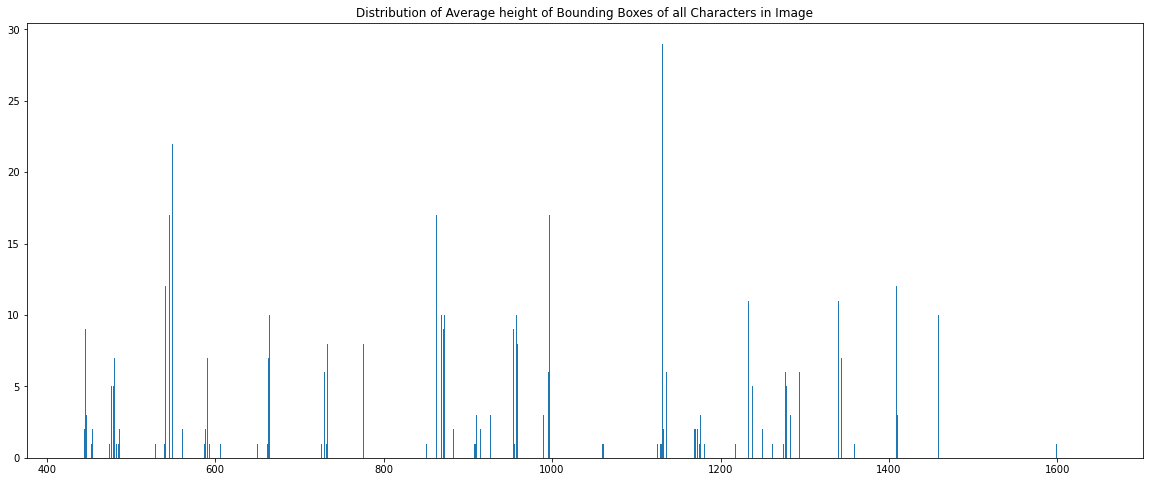

Size of Input Array :  (680, 1)



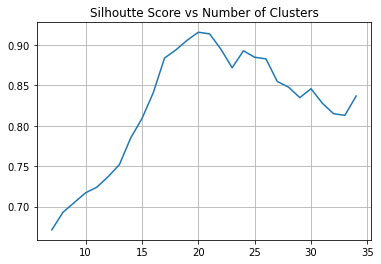

For K= 20, Silhoutte score is max: 0.916

Centroids of image : [545, 1176, 912, 1235, 1409, 730, 995, 1344, 1630, 479, 1130, 867, 590, 662, 1280, 956, 1063, 1458, 445, 776]

Centriod:545,  Name of Image: page2_cropped_0.jpg
box26: {'top_left': [414, 1678], 'top_right': [1462, 1678], 'bottom_left': [414, 1634], 'bottom_right': [1462, 1634]}


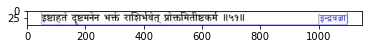


Centriod:1176,  Name of Image: page2_cropped_1.jpg
box27: {'top_left': [416, 1046], 'top_right': [980, 1046], 'bottom_left': [416, 1005], 'bottom_right': [980, 1005]}


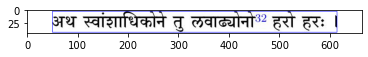


Centriod:912,  Name of Image: page2_cropped_2.jpg
box28: {'top_left': [414, 1309], 'top_right': [988, 1309], 'bottom_left': [414, 1268], 'bottom_right': [988, 1268]}


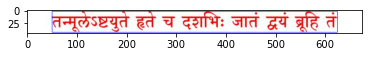


Centriod:1235,  Name of Image: page2_cropped_3.jpg
box29: {'top_left': [414, 989], 'top_right': [1042, 989], 'bottom_left': [414, 945], 'bottom_right': [1042, 945]}


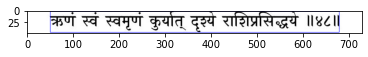


Centriod:1409,  Name of Image: page2_cropped_4.jpg
box30: {'top_left': [689, 806], 'top_right': [1010, 806], 'bottom_left': [689, 773], 'bottom_right': [1010, 773]}


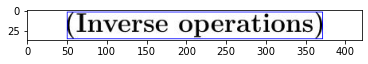


Centriod:730,  Name of Image: page2_cropped_5.jpg
box31: {'top_left': [556, 1486], 'top_right': [1144, 1486], 'bottom_left': [556, 1453], 'bottom_right': [1144, 1453]}


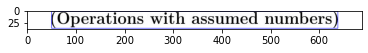


Centriod:995,  Name of Image: page2_cropped_6.jpg
box32: {'top_left': [414, 1223], 'top_right': [981, 1223], 'bottom_left': [414, 1187], 'bottom_right': [981, 1187]}


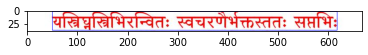


Centriod:1344,  Name of Image: page2_cropped_7.jpg
box33: {'top_left': [338, 873], 'top_right': [700, 873], 'bottom_left': [338, 836], 'bottom_right': [700, 836]}


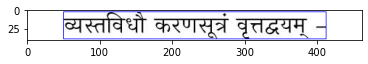


Centriod:1630,  Name of Image: page2_cropped_8.jpg
box34: {'top_left': [719, 608], 'top_right': [985, 608], 'bottom_left': [719, 526], 'bottom_right': [985, 526]}


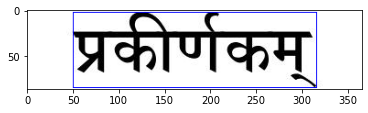


Centriod:479,  Name of Image: page2_cropped_9.jpg
box35: {'top_left': [340, 1738], 'top_right': [748, 1738], 'bottom_left': [340, 1695], 'bottom_right': [748, 1695]}


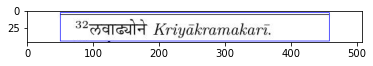


Centriod:1130,  Name of Image: page2_cropped_10.jpg
box36: {'top_left': [416, 1089], 'top_right': [1454, 1089], 'bottom_left': [416, 1048], 'bottom_right': [1454, 1048]}


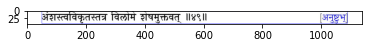


Centriod:867,  Name of Image: page2_cropped_11.jpg
box37: {'top_left': [414, 1356], 'top_right': [1561, 1356], 'bottom_left': [414, 1312], 'bottom_right': [1561, 1312]}


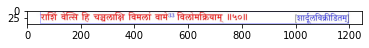


Centriod:590,  Name of Image: page2_cropped_12.jpg
box38: {'top_left': [414, 1631], 'top_right': [1115, 1631], 'bottom_left': [414, 1590], 'bottom_right': [1115, 1590]}


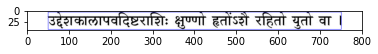


Centriod:662,  Name of Image: page2_cropped_13.jpg
box39: {'top_left': [339, 1554], 'top_right': [648, 1554], 'bottom_left': [339, 1517], 'bottom_right': [648, 1517]}


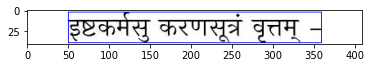


Centriod:1280,  Name of Image: page2_cropped_14.jpg
box40: {'top_left': [414, 942], 'top_right': [923, 942], 'bottom_left': [414, 901], 'bottom_right': [923, 901]}


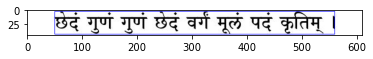


Centriod:956,  Name of Image: page2_cropped_15.jpg
box41: {'top_left': [414, 1266], 'top_right': [1032, 1266], 'bottom_left': [414, 1225], 'bottom_right': [1032, 1225]}


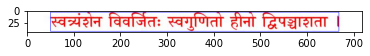


Centriod:1063,  Name of Image: page2_cropped_16.jpg
box42: {'top_left': [340, 1153], 'top_right': [484, 1153], 'bottom_left': [340, 1119], 'bottom_right': [484, 1119]}


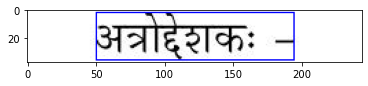


Centriod:1458,  Name of Image: page2_cropped_17.jpg
box43: {'top_left': [767, 759], 'top_right': [928, 759], 'bottom_left': [767, 722], 'bottom_right': [928, 722]}


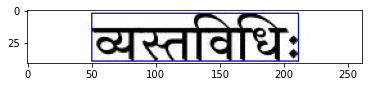


Centriod:445,  Name of Image: page2_cropped_18.jpg
box44: {'top_left': [364, 1770], 'top_right': [733, 1770], 'bottom_left': [364, 1735], 'bottom_right': [733, 1735]}


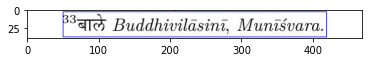


Centriod:776,  Name of Image: page2_cropped_19.jpg
box45: {'top_left': [797, 1446], 'top_right': [902, 1446], 'bottom_left': [797, 1401], 'bottom_right': [902, 1401]}


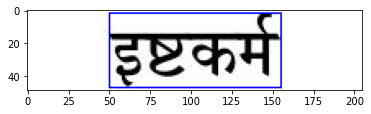






Shape of image :  (2200, 1700, 3)


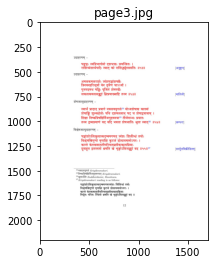

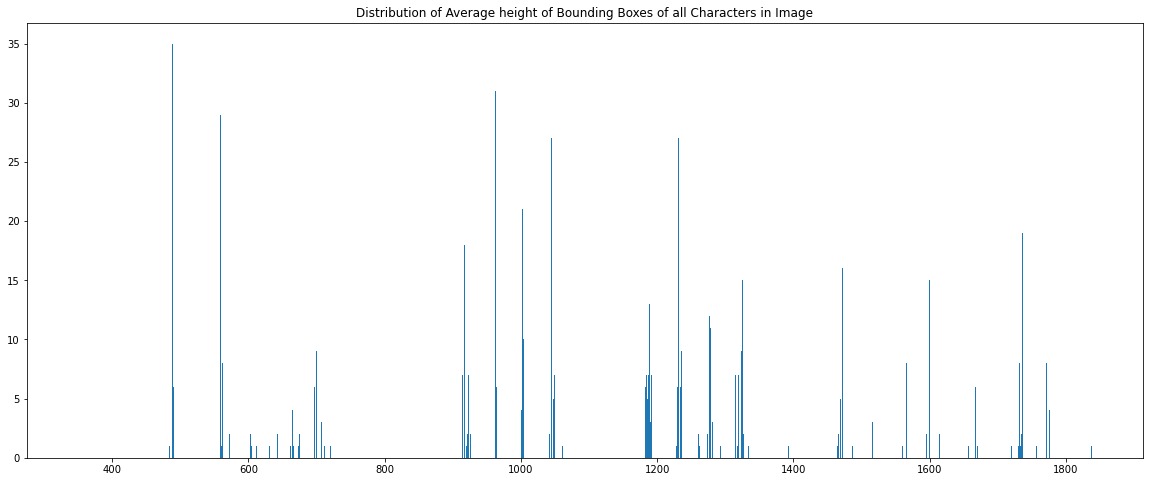

Size of Input Array :  (965, 1)



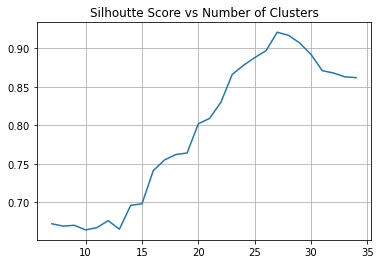

For K= 27, Silhoutte score is max: 0.921

Centroids of image : [1773, 920, 560, 1322, 1562, 1111, 457, 666, 1187, 1002, 1232, 1470, 1046, 1666, 523, 1734, 1394, 1276, 962, 634, 1516, 1601, 489, 1834, 701, 350, 602]

Centriod:1773,  Name of Image: page3_cropped_0.jpg
box46: {'top_left': [410, 446], 'top_right': [933, 446], 'bottom_left': [410, 401], 'bottom_right': [933, 401]}


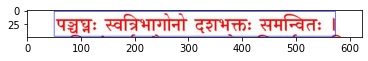


Centriod:920,  Name of Image: page3_cropped_1.jpg
box47: {'top_left': [414, 1303], 'top_right': [1561, 1303], 'bottom_left': [414, 1258], 'bottom_right': [1561, 1258]}


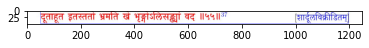


Centriod:560,  Name of Image: page3_cropped_2.jpg
box48: {'top_left': [405, 1657], 'top_right': [903, 1657], 'bottom_left': [405, 1624], 'bottom_right': [903, 1624]}


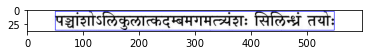


Centriod:1322,  Name of Image: page3_cropped_3.jpg
box49: {'top_left': [414, 900], 'top_right': [1094, 900], 'bottom_left': [414, 859], 'bottom_right': [1094, 859]}


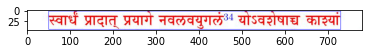


Centriod:1562,  Name of Image: page3_cropped_4.jpg
box50: {'top_left': [414, 659], 'top_right': [864, 659], 'bottom_left': [414, 618], 'bottom_right': [864, 618]}


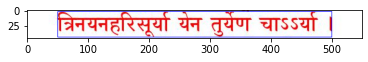


Centriod:1111,  Name of Image: page3_cropped_5.jpg
box51: {'top_left': [338, 1106], 'top_right': [586, 1106], 'bottom_left': [338, 1070], 'bottom_right': [586, 1070]}


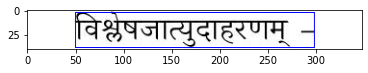


Centriod:457,  Name of Image: page3_cropped_6.jpg
box52: {'top_left': [405, 1761], 'top_right': [950, 1761], 'bottom_left': [405, 1727], 'bottom_right': [950, 1727]}


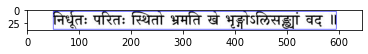


Centriod:666,  Name of Image: page3_cropped_7.jpg
box53: {'top_left': [364, 1552], 'top_right': [810, 1552], 'bottom_left': [364, 1514], 'bottom_right': [810, 1514]}


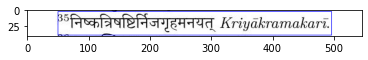


Centriod:1187,  Name of Image: page3_cropped_8.jpg
box54: {'top_left': [414, 1032], 'top_right': [1449, 1032], 'bottom_left': [414, 991], 'bottom_right': [1449, 991]}


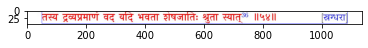


Centriod:1002,  Name of Image: page3_cropped_9.jpg
box55: {'top_left': [414, 1218], 'top_right': [1004, 1218], 'bottom_left': [414, 1177], 'bottom_right': [1004, 1177]}


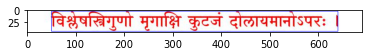


Centriod:1232,  Name of Image: page3_cropped_10.jpg
box56: {'top_left': [414, 989], 'top_right': [1044, 989], 'bottom_left': [414, 948], 'bottom_right': [1044, 948]}


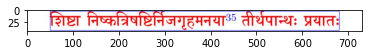


Centriod:1470,  Name of Image: page3_cropped_11.jpg
box57: {'top_left': [414, 750], 'top_right': [1455, 750], 'bottom_left': [414, 709], 'bottom_right': [1455, 709]}


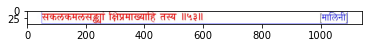


Centriod:1046,  Name of Image: page3_cropped_12.jpg
box58: {'top_left': [414, 1175], 'top_right': [1045, 1175], 'bottom_left': [414, 1134], 'bottom_right': [1045, 1134]}


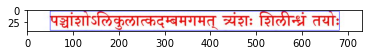


Centriod:1666,  Name of Image: page3_cropped_13.jpg
box59: {'top_left': [338, 546], 'top_right': [479, 546], 'bottom_left': [338, 519], 'bottom_right': [479, 519]}


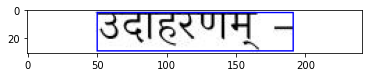


Centriod:523,  Name of Image: page3_cropped_14.jpg
box60: {'top_left': [405, 1694], 'top_right': [891, 1694], 'bottom_left': [405, 1661], 'bottom_right': [891, 1661]}


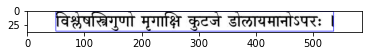


Centriod:1734,  Name of Image: page3_cropped_15.jpg
box61: {'top_left': [614, 484], 'top_right': [1454, 484], 'bottom_left': [614, 443], 'bottom_right': [1454, 443]}


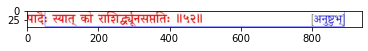


Centriod:1394,  Name of Image: page3_cropped_16.jpg
box62: {'top_left': [338, 823], 'top_right': [561, 823], 'bottom_left': [338, 787], 'bottom_right': [561, 787]}


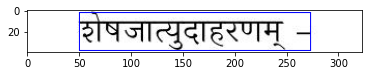


Centriod:1276,  Name of Image: page3_cropped_17.jpg
box63: {'top_left': [414, 945], 'top_right': [1146, 945], 'bottom_left': [414, 902], 'bottom_right': [1146, 902]}


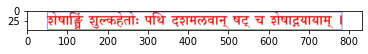


Centriod:962,  Name of Image: page3_cropped_18.jpg
box64: {'top_left': [414, 1253], 'top_right': [943, 1253], 'bottom_left': [414, 1220], 'bottom_right': [943, 1220]}


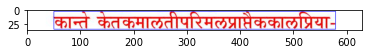


Centriod:634,  Name of Image: page3_cropped_19.jpg
box65: {'top_left': [364, 1584], 'top_right': [774, 1584], 'bottom_left': [364, 1546], 'bottom_right': [774, 1546]}


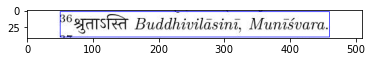


Centriod:1516,  Name of Image: page3_cropped_20.jpg
box66: {'top_left': [414, 705], 'top_right': [814, 705], 'bottom_left': [414, 662], 'bottom_right': [814, 662]}


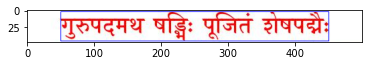


Centriod:1601,  Name of Image: page3_cropped_21.jpg
box67: {'top_left': [416, 618], 'top_right': [816, 618], 'bottom_left': [416, 581], 'bottom_right': [816, 581]}


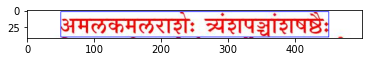


Centriod:489,  Name of Image: page3_cropped_22.jpg
box68: {'top_left': [405, 1724], 'top_right': [845, 1724], 'bottom_left': [405, 1697], 'bottom_right': [845, 1697]}


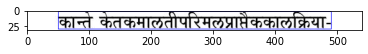


Centriod:1834,  Name of Image: page3_cropped_23.jpg
box69: {'top_left': [339, 378], 'top_right': [479, 378], 'bottom_left': [339, 351], 'bottom_right': [479, 351]}


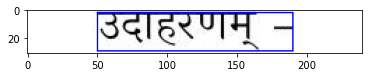


Centriod:701,  Name of Image: page3_cropped_24.jpg
box70: {'top_left': [340, 1519], 'top_right': [748, 1519], 'bottom_left': [340, 1477], 'bottom_right': [748, 1477]}


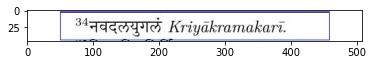


Centriod:350,  Name of Image: page3_cropped_25.jpg
box71: {'top_left': [837, 1860], 'top_right': [863, 1860], 'bottom_left': [837, 1840], 'bottom_right': [863, 1840]}


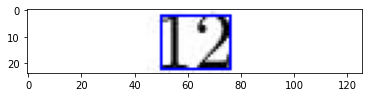


Centriod:602,  Name of Image: page3_cropped_26.jpg
box72: {'top_left': [364, 1609], 'top_right': [800, 1609], 'bottom_left': [364, 1582], 'bottom_right': [800, 1582]}


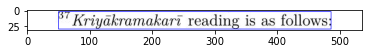






Shape of image :  (2200, 1700, 3)


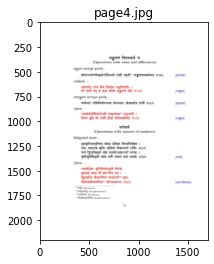

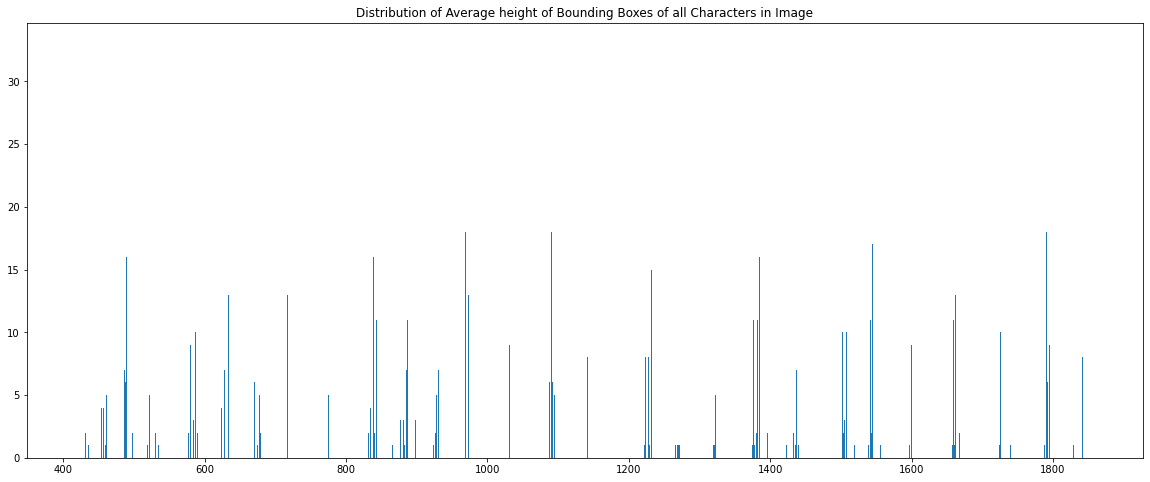

Size of Input Array :  (924, 1)



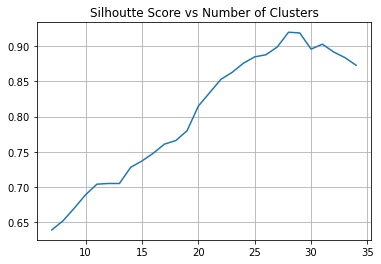

For K= 28, Silhoutte score is max: 0.92

Centroids of image : [1662, 719, 1273, 926, 524, 1437, 1091, 1839, 1543, 585, 840, 424, 1725, 971, 1382, 1229, 1029, 674, 1792, 884, 1503, 630, 489, 774, 1599, 1142, 1322, 458]

Centriod:1662,  Name of Image: page4_cropped_0.jpg
box73: {'top_left': [414, 559], 'top_right': [1462, 559], 'bottom_left': [414, 516], 'bottom_right': [1462, 516]}


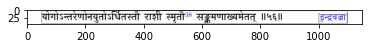


Centriod:719,  Name of Image: page4_cropped_1.jpg
box74: {'top_left': [414, 1503], 'top_right': [826, 1503], 'bottom_left': [414, 1462], 'bottom_right': [826, 1462]}


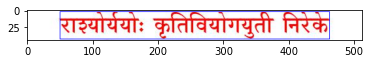


Centriod:1273,  Name of Image: page4_cropped_2.jpg
box75: {'top_left': [414, 949], 'top_right': [970, 949], 'bottom_left': [414, 908], 'bottom_right': [970, 908]}


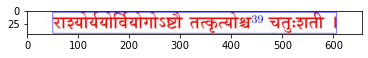


Centriod:926,  Name of Image: page4_cropped_3.jpg
box76: {'top_left': [414, 1294], 'top_right': [1063, 1294], 'bottom_left': [414, 1253], 'bottom_right': [1063, 1253]}


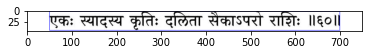


Centriod:524,  Name of Image: page4_cropped_4.jpg
box77: {'top_left': [340, 1696], 'top_right': [748, 1696], 'bottom_left': [340, 1654], 'bottom_right': [748, 1654]}


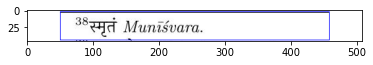


Centriod:1437,  Name of Image: page4_cropped_5.jpg
box78: {'top_left': [338, 781], 'top_right': [698, 781], 'bottom_left': [338, 743], 'bottom_right': [698, 743]}


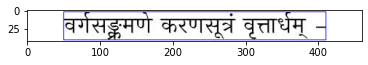


Centriod:1091,  Name of Image: page4_cropped_6.jpg
box79: {'top_left': [543, 1124], 'top_right': [1157, 1124], 'bottom_left': [543, 1091], 'bottom_right': [1157, 1091]}


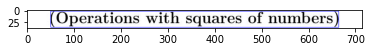


Centriod:1839,  Name of Image: page4_cropped_7.jpg
box80: {'top_left': [692, 389], 'top_right': [1007, 389], 'bottom_left': [692, 339], 'bottom_right': [1007, 339]}


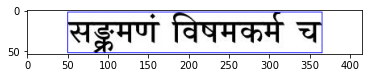


Centriod:1543,  Name of Image: page4_cropped_8.jpg
box81: {'top_left': [414, 676], 'top_right': [926, 676], 'bottom_left': [414, 639], 'bottom_right': [926, 639]}


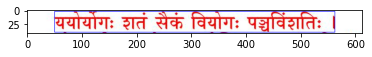


Centriod:585,  Name of Image: page4_cropped_9.jpg
box82: {'top_left': [414, 1638], 'top_right': [1521, 1638], 'bottom_left': [414, 1596], 'bottom_right': [1521, 1596]}


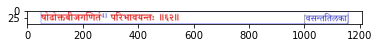


Centriod:840,  Name of Image: page4_cropped_10.jpg
box83: {'top_left': [414, 1383], 'top_right': [1430, 1383], 'bottom_left': [414, 1340], 'bottom_right': [1430, 1340]}


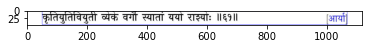


Centriod:424,  Name of Image: page4_cropped_11.jpg
box84: {'top_left': [365, 1795], 'top_right': [706, 1795], 'bottom_left': [365, 1756], 'bottom_right': [706, 1756]}


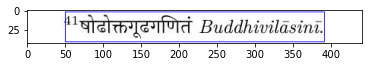


Centriod:1725,  Name of Image: page4_cropped_12.jpg
box85: {'top_left': [338, 493], 'top_right': [661, 493], 'bottom_left': [338, 455], 'bottom_right': [661, 455]}


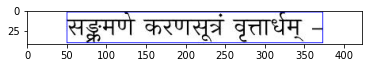


Centriod:971,  Name of Image: page4_cropped_13.jpg
box86: {'top_left': [414, 1251], 'top_right': [1003, 1251], 'bottom_left': [414, 1210], 'bottom_right': [1003, 1210]}


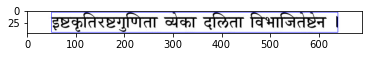


Centriod:1382,  Name of Image: page4_cropped_14.jpg
box87: {'top_left': [414, 839], 'top_right': [1462, 839], 'bottom_left': [414, 799], 'bottom_right': [1462, 799]}


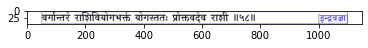


Centriod:1229,  Name of Image: page4_cropped_15.jpg
box88: {'top_left': [414, 992], 'top_right': [1454, 992], 'bottom_left': [414, 951], 'bottom_right': [1454, 951]}


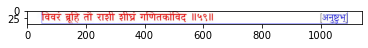


Centriod:1029,  Name of Image: page4_cropped_16.jpg
box89: {'top_left': [338, 1188], 'top_right': [596, 1188], 'bottom_left': [338, 1154], 'bottom_right': [596, 1154]}


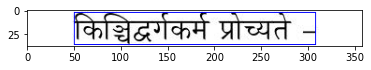


Centriod:674,  Name of Image: page4_cropped_17.jpg
box90: {'top_left': [414, 1546], 'top_right': [816, 1546], 'bottom_left': [414, 1505], 'bottom_right': [816, 1505]}


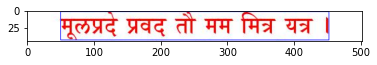


Centriod:1792,  Name of Image: page4_cropped_18.jpg
box91: {'top_left': [532, 424], 'top_right': [1168, 424], 'bottom_left': [532, 391], 'bottom_right': [1168, 391]}


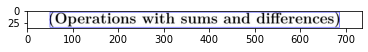


Centriod:884,  Name of Image: page4_cropped_19.jpg
box92: {'top_left': [414, 1338], 'top_right': [998, 1338], 'bottom_left': [414, 1297], 'bottom_right': [998, 1297]}


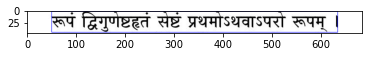


Centriod:1503,  Name of Image: page4_cropped_20.jpg
box93: {'top_left': [414, 718], 'top_right': [1454, 718], 'bottom_left': [414, 676], 'bottom_right': [1454, 676]}


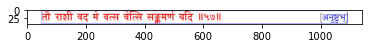


Centriod:630,  Name of Image: page4_cropped_21.jpg
box94: {'top_left': [414, 1593], 'top_right': [888, 1593], 'bottom_left': [414, 1550], 'bottom_right': [888, 1550]}


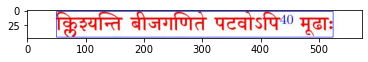


Centriod:489,  Name of Image: page4_cropped_22.jpg
box95: {'top_left': [364, 1729], 'top_right': [667, 1729], 'bottom_left': [364, 1690], 'bottom_right': [667, 1690]}


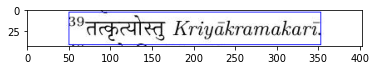


Centriod:774,  Name of Image: page4_cropped_23.jpg
box96: {'top_left': [338, 1441], 'top_right': [452, 1441], 'bottom_left': [338, 1408], 'bottom_right': [452, 1408]}


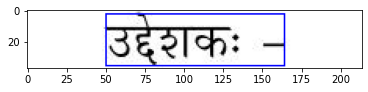


Centriod:1599,  Name of Image: page4_cropped_24.jpg
box97: {'top_left': [340, 617], 'top_right': [484, 617], 'bottom_left': [340, 583], 'bottom_right': [484, 583]}


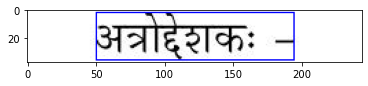


Centriod:1142,  Name of Image: page4_cropped_25.jpg
box98: {'top_left': [797, 1077], 'top_right': [903, 1077], 'bottom_left': [797, 1039], 'bottom_right': [903, 1039]}


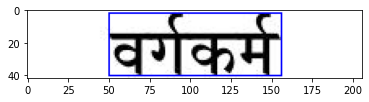


Centriod:1322,  Name of Image: page4_cropped_26.jpg
box99: {'top_left': [338, 893], 'top_right': [452, 893], 'bottom_left': [338, 860], 'bottom_right': [452, 860]}


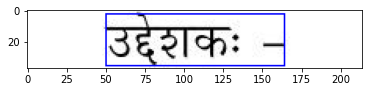


Centriod:458,  Name of Image: page4_cropped_27.jpg
box100: {'top_left': [365, 1751], 'top_right': [597, 1751], 'bottom_left': [365, 1727], 'bottom_right': [597, 1727]}


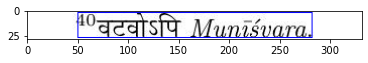

In [240]:

if __name__ == '__main__':
    
    #Extracting JPEG images from pdf file
    images = convert_from_path('Sanskrit_Text.pdf')
    
    lst_image = []
    for i in range(len(images)):
        name = 'page'+ str(i) +'.jpg'
        images[i].save(name, 'JPEG')
        lst_image.append(name)
    
    print('List of image names: ', lst_image)
    
    #Dictionary to store bounding boxes of each lines
    json_dict = {}
    
    
    count=0
    for img_nm in lst_image[:]:
        
        #Reading image and converting it from BGR TO RGB format
        img = cv2.cvtColor(cv2.imread(img_nm), cv2.COLOR_BGR2RGB)
        print("Shape of image : ",img.shape)
        
        plt.imshow(img)
        plt.title(img_nm)
        plt.show()

        #print('Text Extracted for {} is: '.format(img_nm))
        #OCR_text(img)
        
        #Bounding boxes of given image
        boxes = pytesseract.image_to_boxes(img, lang='san').splitlines()

        #average height of bounding boxes of each line in image
        val, dict_avg = finding_box_average()

        #Distribution of Average height of Bounding Boxes of all Characters in Image
        dictionary_plotting(dict_avg, "Distribution of Average height of Bounding Boxes of all Characters in Image")

        # Kmean Clustering : to find clusters of average height of lines
        cluster_centers_, labels_ = ClusteringOnAverages(val)

        dict_cenres, lst_center = centroid_with_datapoint_box(cluster_centers_, labels_ )
        print('\nCentroids of image :', lst_center)
        print()

        size = {} #Dictionary to save coordinates of each lines
        
        #Extracting all boxes associated with each centroid
        for i, center in enumerate(lst_center):
            lst = []

            for index in dict_cenres[center]:
                v = boxes[index]
        
                #Chars which are not in range of +/- 50 from cluster centroid are outliers.. so removing those points
                if int(v.split( )[2]) not in range(center-50, center+50):
                    continue
                else:   
                    lst.append(v)
            #Finding coordinates of lines from list of bounding boxes
            result = imageCordinatesfromBox(lst)
            size[center] = result
        
        #Cropping images as per text, saving cropped image into jpg file, creating bounding boxes for each text
        nm_lst, json_dict, count = croppingImage(lst_center, size,  img_nm[:-4], count, json_dict)
        
        #List of all Image names created from each image
        cropped_img_names.extend(nm_lst)
        print("\n\n\n")



In [241]:
#JSON file creation form bounding box

json_object = json.dumps(json_dict)
print(json_object)
with open("Bounding_Box1.json", 'w') as file:
    json.dump(json_object, file)

{"box0": {"top_left": [405, 1691], "top_right": [745, 1691], "bottom_left": [405, 1658], "bottom_right": [745, 1658]}, "box1": {"top_left": [414, 668], "top_right": [1521, 668], "bottom_left": [414, 626], "bottom_right": [1521, 626]}, "box2": {"top_left": [414, 479], "top_right": [1462, 479], "bottom_left": [414, 438], "bottom_right": [1462, 438]}, "box3": {"top_left": [414, 859], "top_right": [1471, 859], "bottom_left": [414, 817], "bottom_right": [1471, 817]}, "box4": {"top_left": [364, 1788], "top_right": [710, 1788], "bottom_left": [364, 1759], "bottom_right": [710, 1759]}, "box5": {"top_left": [340, 1611], "top_right": [868, 1611], "bottom_left": [340, 1575], "bottom_right": [868, 1575]}, "box6": {"top_left": [338, 546], "top_right": [695, 546], "bottom_left": [338, 509], "bottom_right": [695, 509]}, "box7": {"top_left": [414, 814], "top_right": [1099, 814], "bottom_left": [414, 773], "bottom_right": [1099, 773]}, "box8": {"top_left": [414, 623], "top_right": [839, 623], "bottom_l